# Task 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# pytorch
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

from torch import nn
import torch.nn.functional as F

2.5.1+cu121
0.20.1+cu121


In [2]:
from sklearn.datasets import fetch_openml

images, labels = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas")
labels = labels.astype(int) 

In [3]:
print(images.shape)
print(labels.shape)

(70000, 784)
(70000,)


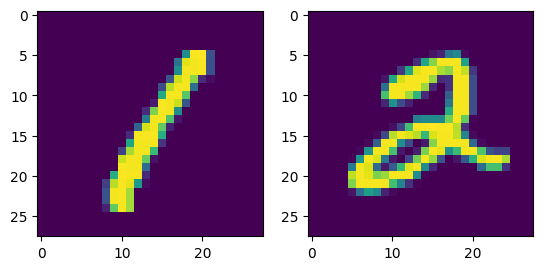

In [4]:
dataset = images[np.logical_or(labels == 1,labels == 2)]
target = labels[np.logical_or(labels == 1,labels == 2)]

plt.subplot(1,2,1)
plt.imshow(dataset[0].reshape((28,28)))
plt.subplot(1,2,2)
plt.imshow(dataset[1].reshape((28,28)))

In [5]:
angles = np.arange(0, 360, 30)
angle_count = len(angles)

In [6]:
def rotate_image(image, angle):
    # rotate the image using scipy
    rotated = scipy.ndimage.rotate(image.reshape((28,28)), angle, reshape=False, mode='constant', cval=0)

    return np.clip(rotated, 0, 255).astype(np.uint8)

In [7]:
data_len = len(dataset)


dataset_rotated = np.zeros((data_len, angle_count, 28, 28), dtype=np.uint8)
target_rotated = np.zeros((data_len, angle_count), dtype=np.uint8)

In [8]:
for i, image in enumerate(dataset):
    for j, angle in enumerate(angles):
        dataset_rotated[i][j] = rotate_image(image, angle)
        target_rotated[i][j] = target[i]

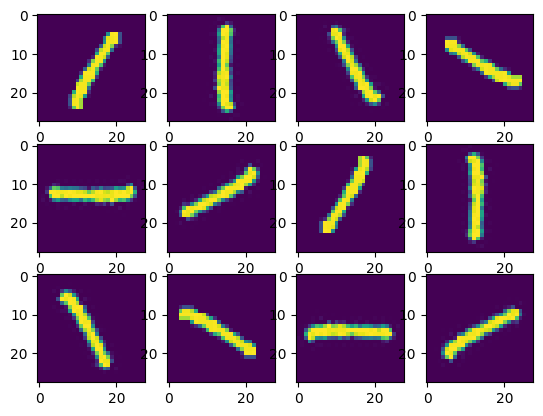

In [9]:
for i in range(len(dataset_rotated[0])):
    plt.subplot(3,4,i+1)
    plt.imshow(dataset_rotated[0][i])

In [10]:
data_norm = dataset_rotated / 255.

In [11]:
np.savez("data.npz", data_norm=data_norm, target_rotated=target_rotated)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data_norm, target_rotated, test_size=0.2, shuffle=True, random_state=12345)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(11893, 12, 28, 28)
(11893, 12)
(2974, 12, 28, 28)
(2974, 12)


In [13]:
X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train).int()
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test).int()


batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt)
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

dataset_test = TensorDataset(X_test_pt, Y_test_pt)
test_dl = DataLoader(dataset_test, batch_size=1, shuffle=True, num_workers=0, drop_last=True)

In [38]:

class Encoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()

        self.conv1 = nn.Conv2d(1, hidden_channels, kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels*2,kernel_size=3, stride=2, padding=1) 

        self.conv3 = nn.Conv2d(hidden_channels*2, hidden_channels*4, kernel_size=3, stride=2, padding=1)

        self.fc1 = nn.Linear(4096, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, int(hidden_channels/2))
        
        self.fc_mu = nn.Linear(in_features=int(hidden_channels/2),
                               out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=int(hidden_channels/2),
                                   out_features=latent_dim)

        self.activation = nn.ReLU()

    def forward(self, x):

        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))

        x = x.view(x.shape[0], -1) #flatten
    
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        
        x_mu = self.fc_mu(x)

        x_logvar = self.fc_logvar(x)

        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        self.conv1 = nn.ConvTranspose2d(hidden_channels, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.conv2 = nn.ConvTranspose2d(hidden_channels*2, hidden_channels,kernel_size=3, stride=2, padding=1, output_padding=1) 

        self.conv3 = nn.ConvTranspose2d(hidden_channels*4, hidden_channels*2, kernel_size=3, stride=2, padding=1)

        self.fc1 = nn.Linear(hidden_channels, 4096)
        self.fc2 = nn.Linear(int(hidden_channels/2), hidden_channels )

        self.fc = nn.Linear(latent_dim, int(hidden_channels/2))


        self.activation = nn.ReLU()


    def forward(self, x):
        x = self.activation(self.fc(x))
        
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc1(x))
        
        
        x = x.view(x.size(0), self.hidden_channels*4, 4, 4)
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv2(x))
        out = torch.sigmoid(self.conv1(x)) # final activation sigmoid (works with BCELoss as reconstruction loss)
        return out

# Full VAE/AE Model

use_VAE = True #False: AE, True: VAE

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)

        #VAE/AE
        if use_VAE:
          z = self.latent_sample(latent_mu, latent_logvar)
        else:
          z = latent_mu

        x_recon = self.decoder(z)

        return x_recon, latent_mu, latent_logvar

    # sampling function (reparametrization trick)
    def latent_sample(self, mu, logvar):

        if self.training: 
          sigma = (0.5*logvar).exp()
          z = mu + sigma * torch.randn_like(sigma)
          return z

        else:
          return mu

In [15]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# of GPUs available:  1
First GPU type:  Tesla P100-PCIE-16GB
Computation device: cuda



In [39]:

hidden_channels = 64
latent_dim = 16 

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_vae = VAE(encoder, decoder)

print(model_vae)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model_vae.cuda(), input_size=(1,28,28))
else:
  summary(model_vae, input_size=(1,28,28))

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=4096, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc_mu): Linear(in_features=32, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=64, out_features=4096, bias=True)
    (fc2): Linear(in_features=32, out_features=64

In [17]:

model_vae.to(device)

model_vae.eval()

x,_ = next(iter(train_dl))

for i in range(angle_count):
    x_rot = x[:, i]
    x_rot = torch.reshape(x_rot, [len(x_rot),1,28,28])

    x_rot =x_rot.to(device)

    xtilde,mu,logv = model_vae(x_rot)

print(mu.shape)
print(xtilde.shape)

torch.Size([128, 16])
torch.Size([128, 1, 28, 28])


In [44]:
beta_par = 4.

# VAE loss
def vae_loss(recon_x, x, mu, logvar):

  recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

  if use_VAE:
    # closed form of KL divergence for normal priors: (-1/2 sum (1 + log sigma^2 - mu^2 - sigma^2))
      
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  else:
    kldivergence = 0.0

  return recon_loss + beta_par * kldivergence, recon_loss, beta_par * kldivergence

In [19]:
# Training

hidden_channels = 64
latent_dim = 16 

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_vae = VAE(encoder, decoder)

model_vae = model_vae.to(device)


# Optimizer
LR = 1.e-3
opt = torch.optim.Adam(params=model_vae.parameters(), lr=LR, weight_decay=1e-5)

In [20]:
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            #print(f"\nBest validation loss: {self.best_valid_loss}")
            #print(f"Saving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion
                }, 'vae_model.pth')

In [21]:
import time

save_best_model = SaveBestModel() #initialize checkpoint function

epochs = 30
hist_loss = []
hist_kloss = []
hist_rloss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    model_vae.train()
    train_loss = 0.
    train_rloss = 0.
    train_kloss = 0.
    counter = 0

    for xb, _ in train_dl:
        for i in range(angle_count):
            counter += 1
            x_rot = xb[:, i]
            x_rot = torch.reshape(x_rot, [len(x_rot),1,28,28])

            x_rot =x_rot.to(device)

            recon_x, mu, logvar = model_vae(x_rot)


            loss, rloss, kloss = vae_loss(recon_x, x_rot, mu, logvar)

            train_loss += loss.item()
            train_rloss += rloss.item()
            train_kloss += kloss.item()

            # backpropagation
            opt.zero_grad()
            loss.backward()
            opt.step()


    train_loss /= counter
    train_rloss /= counter
    train_kloss /= counter

    hist_loss.append(train_loss)
    hist_rloss.append(train_rloss)
    hist_kloss.append(train_kloss)

    save_best_model(train_loss, epoch, model_vae, opt, vae_loss)


    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.2f, train loss: %.2f, train reco loss: %.2f, train kl loss: %.2f"
          % (epoch+1, elapsed_time, train_loss, train_rloss, train_kloss))

epoch: 1, time(s): 6.90, train loss: 24761.39, train reco loss: 23911.42, train kl loss: 849.97
epoch: 2, time(s): 6.63, train loss: 20586.51, train reco loss: 18585.27, train kl loss: 2001.24
epoch: 3, time(s): 6.65, train loss: 19950.89, train reco loss: 17708.46, train kl loss: 2242.44
epoch: 4, time(s): 6.66, train loss: 19186.10, train reco loss: 16642.20, train kl loss: 2543.90
epoch: 5, time(s): 6.59, train loss: 18796.63, train reco loss: 16124.62, train kl loss: 2672.01
epoch: 6, time(s): 6.65, train loss: 18568.49, train reco loss: 15827.10, train kl loss: 2741.39
epoch: 7, time(s): 6.59, train loss: 18462.50, train reco loss: 15659.13, train kl loss: 2803.36
epoch: 8, time(s): 6.59, train loss: 18340.44, train reco loss: 15498.03, train kl loss: 2842.41
epoch: 9, time(s): 6.67, train loss: 18223.64, train reco loss: 15356.59, train kl loss: 2867.06
epoch: 10, time(s): 6.59, train loss: 18205.30, train reco loss: 15310.83, train kl loss: 2894.47
epoch: 11, time(s): 6.66, trai

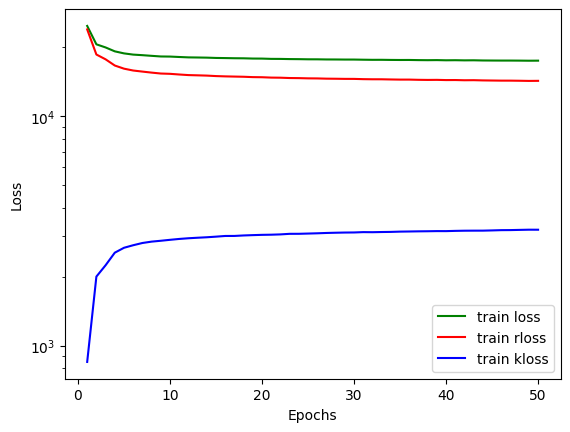

In [22]:
# training loss plot
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_rloss)+1), hist_rloss, color='red', linestyle='-', label='train rloss')
plt.plot(range(1,len(hist_kloss)+1), hist_kloss, color='blue', linestyle='-', label='train kloss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.show()

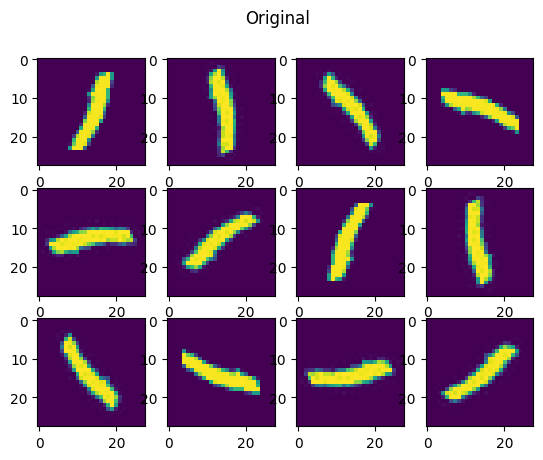

In [23]:
x,_ = next(iter(test_dl))
image = x[0]

plt.suptitle("Original")
for i in range(len(image)):
    plt.subplot(3,4,i+1)
    plt.imshow(image[i])    

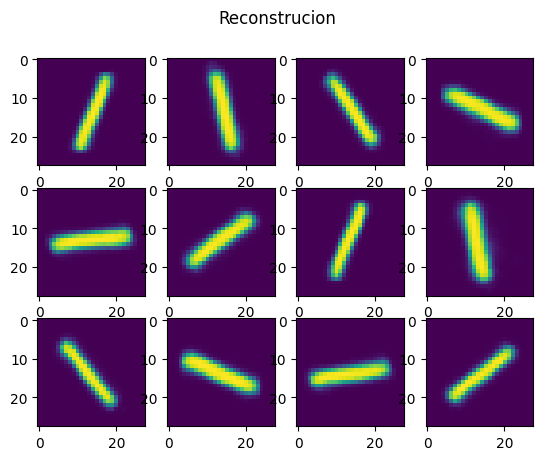

In [24]:
plt.suptitle("Reconstrucion")
with torch.no_grad():
    for i in range(angle_count):
        x_rot = x[:, i]
        x_rot = torch.reshape(x_rot, [len(x_rot),1,28,28])

        x_rot =x_rot.to(device)

        xtilde,_,_ = model_vae(x_rot)
        
        plt.subplot(3,4,i+1)
        plt.imshow(xtilde[0].reshape((28,28)).cpu())    

In [45]:
checkpoint = torch.load('./vae_model.pth', weights_only=False, map_location=torch.device('cpu'))
print('Best model at epoch: ', checkpoint['epoch'])

model_vae = VAE(encoder, decoder)
model_vae.load_state_dict(checkpoint['model_state_dict'])
model_vae.eval()

Best model at epoch:  49


VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=4096, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc_mu): Linear(in_features=32, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=64, out_features=4096, bias=True)
    (fc2): Linear(in_features=32, out_features=64

In [26]:
dataset_pt = torch.Tensor(data_norm).float()
target_pt = torch.Tensor(target_rotated).int()

batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

dataset_td = TensorDataset(dataset_pt, target_pt)
dataset_dl = DataLoader(dataset_td, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [27]:
encoded_dataset = np.empty(shape=(len(dataset_dl) * batch_size, angle_count, latent_dim))

with torch.no_grad():
  for idx, (xb, _) in enumerate(dataset_dl):
    for i in range(angle_count):
        x_rot = xb[:, i]
        x_rot = torch.reshape(x_rot, [len(x_rot),1,28,28])
        x_rot =x_rot.to(device)
        _, mu, _ = model_vae(x_rot)
        encoded_dataset[batch_size*idx:batch_size*(idx+1),i,:] = mu.cpu()

In [28]:
target_encoded = target_rotated[:len(encoded_dataset)]

In [29]:
np.savez("latent_space.npz", encoded_dataset=encoded_dataset, target_encoded=target_encoded)